In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import numpy as np

In [2]:
import pm4py

In [3]:
log = pm4py.read_xes('BPI_Challenge_2012.xes')
df = pm4py.convert_to_dataframe(log)

c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\pm4py\util\dt_parsing\parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 13087/13087 [00:08<00:00, 1552.84it/s]


In [4]:
# translating the Dutch phrases in the 'concept:name' column to English
translation_dict = {
    'W_Completeren aanvraag': 'W_Complete request',
    'W_Nabellen offertes': 'W_Follow up quotes',
    'W_Nabellen incomplete dossiers': 'W_Follow up incomplete files',
    'W_Valideren aanvraag': 'W_Validate request',
    'W_Afhandelen leads': 'W_Handle leads',
    'A_SUBMITTED': 'A_SUBMITTED',
    'A_PARTLYSUBMITTED': 'A_PARTLYSUBMITTED',
    'A_DECLINED': 'A_DECLINED',
    'A_PREACCEPTED': 'A_PREACCEPTED',
    'O_SENT': 'O_SENT',
    'O_CREATED': 'O_CREATED',
    'O_SELECTED': 'O_SELECTED',
    'A_ACCEPTED': 'A_ACCEPTED',
    'A_FINALIZED': 'A_FINALIZED',
    'O_CANCELLED': 'O_CANCELLED',
    'O_SENT_BACK': 'O_SENT_BACK',
    'A_CANCELLED': 'O_CANCELLED',
    'A_REGISTERED': 'A_REGISTERED',
    'A_ACTIVATED': 'A_ACTIVATED',
    'A_APPROVED': 'A_APPROVED',
    'O_ACCEPTED': 'O_ACCEPTED',
    'O_DECLINED': 'O_DECLINED',
    'W_Beoordelen fraude': 'W_Evaluate fraud',
    'W_Wijzigen contractgegevens': 'W_Modify contract details'
}

In [5]:
df['concept:name_eng'] = df['concept:name'].map(translation_dict)

In [6]:
# adding position to the dataframe
df['position'] = df.groupby('case:concept:name').cumcount() + 1

In [7]:
# Adding the next activity(concept:name) to the dataframe and if the next activity is not available, then it will be fill in with No_Activity
df['next_activity'] = df.groupby('case:concept:name')['concept:name'].shift(-1).fillna('No_Activity')

In [8]:
df.drop(['case:REG_DATE', 'lifecycle:transition'], axis=1, inplace = True)

In [9]:
#df = pd.read_csv('baseline_df.csv')

In [10]:
date1 = pd.to_datetime(df['time:timestamp'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f%z')
date2 = pd.to_datetime(df['time:timestamp'], errors='coerce', format='%Y-%m-%d %H:%M:%S%z')
df['date'] = date1.fillna(date2)

In [11]:
df["date_milliseconds"] = (df['date'] - pd.Timestamp("1970-01-01", tz = "UTC")) // pd.Timedelta('1ms')

In [12]:
df["duration"] = df.groupby("case:concept:name")["date_milliseconds"].shift(-1) - df["date_milliseconds"]

#df["duration"] = df["duration"] / (1000 * 60 * 60)  # Convert milliseconds to hours


In [13]:
df.head(10)

,org:resource,concept:name,time:timestamp,case:concept:name,case:AMOUNT_REQ,concept:name_eng,position,next_activity,date,date_milliseconds,duration
0,112,A_SUBMITTED,2011-10-01 00:38:44.546000+00:00,173688,20000,A_SUBMITTED,1,A_PARTLYSUBMITTED,2011-10-01 00:38:44.546000+00:00,1317429524546,334.0
1,112,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,173688,20000,A_PARTLYSUBMITTED,2,A_PREACCEPTED,2011-10-01 00:38:44.880000+00:00,1317429524880,53026.0
2,112,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,173688,20000,A_PREACCEPTED,3,W_Completeren aanvraag,2011-10-01 00:39:37.906000+00:00,1317429577906,969.0
3,112,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,173688,20000,W_Complete request,4,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,1317429578875,39427562.0
4,NaN,W_Completeren aanvraag,2011-10-01 11:36:46.437000+00:00,173688,20000,W_Complete request,5,A_ACCEPTED,2011-10-01 11:36:46.437000+00:00,1317469006437,356871.0
5,10862,A_ACCEPTED,2011-10-01 11:42:43.308000+00:00,173688,20000,A_ACCEPTED,6,O_SELECTED,2011-10-01 11:42:43.308000+00:00,1317469363308,145935.0
6,10862,O_SELECTED,2011-10-01 11:45:09.243000+00:00,173688,20000,O_SELECTED,7,A_FINALIZED,2011-10-01 11:45:09.243000+00:00,1317469509243,0.0
7,10862,A_FINALIZED,2011-10-01 11:45:09.243000+00:00,173688,20000,A_FINALIZED,8,O_CREATED,2011-10-01 11:45:09.243000+00:00,1317469509243,1954.0
8,10862,O_CREATED,2011-10-01 11:45:11.197000+00:00,173688,20000,O_CREATED,9,O_SENT,2011-10-01 11:45:11.197000+00:00,1317469511197,183.0
9,10862,O_SENT,2011-10-01 11:45:11.380000+00:00,173688,20000,O_SENT,10,W_Nabellen offertes,2011-10-01 11:45:11.380000+00:00,1317469511380,174.0


In [14]:
# finding the average duration for each position
position_dict_time = {}
for j in range(1, 176):
    time = []
    for i in (df[df['position'] == j]).index:
        time.append(df["duration"].iloc[i])
    if len(time) > 0:
        position_dict_time[j] = sum(time)/len(time)

In [15]:
# adding the average duration to each position

df['predicted_next_timestamp_milliseconds'] = df['date_milliseconds'] + df['position'].map(lambda x: position_dict_time[x]).fillna(0)
#df["duration"] = df['position'].map(lambda x: position_dict_time[x]).fillna(0) 

In [16]:
df['predicted_next_timestamp'] = df['predicted_next_timestamp_milliseconds'].apply(lambda x: '%d' % x)

In [17]:
# convert the predicted_timestamp to datetime
df['predicted_next_timestamp'] = pd.to_datetime(df['predicted_next_timestamp'], unit='ms')

C:\Users\Aahaan\AppData\Local\Temp\ipykernel_4540\1815087631.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['predicted_next_timestamp'] = pd.to_datetime(df['predicted_next_timestamp'], unit='ms')


In [18]:
df['next_timestamp'] = df.groupby('case:concept:name')['time:timestamp'].shift(-1).fillna(0)
df['next_timestamp_milliseconds'] = df.groupby('case:concept:name')['date_milliseconds'].shift(-1).fillna(0)

In [19]:
df['next_timestamp_milliseconds'] = df['next_timestamp_milliseconds'].apply(lambda x: '%d' % x)
df['predicted_next_timestamp_milliseconds'] = df['predicted_next_timestamp_milliseconds'].apply(lambda x: '%d' % x)

In [20]:
df["time_since_start"] = df.groupby('case:concept:name')["duration"].cumsum().shift(1).fillna(0)

df["time_since_start"] = df["time_since_start"] / (1000*60*60)

In [21]:
df["duration"] = df["duration"].fillna(0)

In [22]:
df["date_hours"] = df["date_milliseconds"] / (1000*60*60)

In [23]:
def nearest_upper_multiple(x, z = 24):
    # Calculate the remainder when x is divided by z
    remainder = x % z
    
    # If remainder is zero, x is already a multiple of z
    if remainder == 0:
        return x
    
    # Otherwise, calculate the nearest upper multiple
    return x + z - remainder

df["nearest_midnight"] = df["date_hours"].apply(lambda x: nearest_upper_multiple(x))

In [24]:
df["time_until_midnight"] = df["nearest_midnight"] - df["date_hours"]

In [25]:
df["hours_of_the_day"] = 24 - df["time_until_midnight"]

In [26]:
df["month"] = df["date"].dt.month

In [27]:
month_conversion_dict = {1: "January",
                         2: "February",
                         3: "March",
                         4: "April",
                         5: "May",
                         6: "June",
                         7: "July",
                         8: "August",
                         9: "September",
                         10: "October",
                         11: "November",
                         12: "December"}

In [28]:
df["month_as_string"] = df["month"].map(month_conversion_dict)

In [29]:
df["day"] = df['date'].dt.dayofweek

In [30]:
day_conversion_dict = {0: "Monday",
                       1: "Tuesday",
                       2: "Wednesday",
                       3: "Thursday",
                       4: "Friday",
                       5: "Saturday",
                       6: "Sunday"}

In [31]:
df["day_as_string"] = df["day"].map(day_conversion_dict)

In [32]:
df["time_elapsed_since_previous_event"] = df["date_milliseconds"] - df.groupby("case:concept:name")["date_milliseconds"].shift(1)

In [33]:
df["time_elapsed_since_previous_event"] = df["time_elapsed_since_previous_event"].fillna(0)

In [34]:
df["next_timestamp_milliseconds"] = df["next_timestamp_milliseconds"].astype(float)

df["next_timestamp_hours"] = df["next_timestamp_milliseconds"] / (1000*60*60)

In [35]:
from sklearn.preprocessing import OneHotEncoder

"""

encoder = OneHotEncoder()

# Fit and transform the data to one-hot encoded format
encoded_array_month = encoder.fit_transform(df[["month_as_string"]]).toarray()

# Get the feature names from the encoder's categories_
feature_names = encoder.categories_[0]

# Create a new DataFrame with one-hot encoded columns and correct column names
df_encoded = pd.DataFrame(encoded_array, columns=feature_names)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
df = pd.concat([df, df_encoded], axis=1)"""

'\n\nencoder = OneHotEncoder()\n\n# Fit and transform the data to one-hot encoded format\nencoded_array_month = encoder.fit_transform(df[["month_as_string"]]).toarray()\n\n# Get the feature names from the encoder\'s categories_\nfeature_names = encoder.categories_[0]\n\n# Create a new DataFrame with one-hot encoded columns and correct column names\ndf_encoded = pd.DataFrame(encoded_array, columns=feature_names)\n\n# Concatenate the original DataFrame with the one-hot encoded DataFrame\ndf = pd.concat([df, df_encoded], axis=1)'

In [36]:
"""encoder = OneHotEncoder()

# Fit and transform the data to one-hot encoded format
encoded_array = encoder.fit_transform(df[["day_as_string"]]).toarray()

# Get the feature names from the encoder's categories_
feature_names = encoder.categories_[0]

# Create a new DataFrame with one-hot encoded columns and correct column names
df_encoded = pd.DataFrame(encoded_array, columns=feature_names)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
df = pd.concat([df, df_encoded], axis=1)"""

'encoder = OneHotEncoder()\n\n# Fit and transform the data to one-hot encoded format\nencoded_array = encoder.fit_transform(df[["day_as_string"]]).toarray()\n\n# Get the feature names from the encoder\'s categories_\nfeature_names = encoder.categories_[0]\n\n# Create a new DataFrame with one-hot encoded columns and correct column names\ndf_encoded = pd.DataFrame(encoded_array, columns=feature_names)\n\n# Concatenate the original DataFrame with the one-hot encoded DataFrame\ndf = pd.concat([df, df_encoded], axis=1)'

In [37]:
encoder = OneHotEncoder()

encoded_array = encoder.fit_transform(df[["concept:name"]]).toarray()


feature_names = encoder.categories_[0]


df_encoded = pd.DataFrame(encoded_array, columns=feature_names)


df = pd.concat([df, df_encoded], axis=1)

In [38]:
df

,org:resource,concept:name,time:timestamp,case:concept:name,case:AMOUNT_REQ,concept:name_eng,position,next_activity,date,date_milliseconds,...,O_SELECTED,O_SENT,O_SENT_BACK,W_Afhandelen leads,W_Beoordelen fraude,W_Completeren aanvraag,W_Nabellen incomplete dossiers,W_Nabellen offertes,W_Valideren aanvraag,W_Wijzigen contractgegevens
0,112,A_SUBMITTED,2011-10-01 00:38:44.546000+00:00,173688,20000,A_SUBMITTED,1,A_PARTLYSUBMITTED,2011-10-01 00:38:44.546000+00:00,1317429524546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,112,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,173688,20000,A_PARTLYSUBMITTED,2,A_PREACCEPTED,2011-10-01 00:38:44.880000+00:00,1317429524880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,112,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,173688,20000,A_PREACCEPTED,3,W_Completeren aanvraag,2011-10-01 00:39:37.906000+00:00,1317429577906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,112,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,173688,20000,W_Complete request,4,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,1317429578875,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,NaN,W_Completeren aanvraag,2011-10-01 11:36:46.437000+00:00,173688,20000,W_Complete request,5,A_ACCEPTED,2011-10-01 11:36:46.437000+00:00,1317469006437,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262195,112,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+00:00,214376,15000,A_PARTLYSUBMITTED,2,W_Afhandelen leads,2012-02-29 23:51:17.423000+00:00,1330559477423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262196,112,W_Afhandelen leads,2012-02-29 23:52:01.287000+00:00,214376,15000,W_Handle leads,3,W_Afhandelen leads,2012-02-29 23:52:01.287000+00:00,1330559521287,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
262197,11169,W_Afhandelen leads,2012-03-01 09:26:46.736000+00:00,214376,15000,W_Handle leads,4,A_DECLINED,2012-03-01 09:26:46.736000+00:00,1330594006736,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
262198,11169,A_DECLINED,2012-03-01 09:27:37.118000+00:00,214376,15000,A_DECLINED,5,W_Afhandelen leads,2012-03-01 09:27:37.118000+00:00,1330594057118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
one_hot_encode_activity_list = list(df_encoded.columns)
linear_regression_extra_predictors_list = ["position", "time_until_midnight", "month", "day", "time_elapsed_since_previous_event", "case:AMOUNT_REQ", "time_since_start", "next_timestamp_hours", "duration", "case:concept:name"]
one_hot_encode_activity_list.extend(linear_regression_extra_predictors_list)

one_hot_encode_activity_list


df_linear_regression = df[one_hot_encode_activity_list]

In [40]:
df_linear_regression = df_linear_regression[df_linear_regression["next_timestamp_hours"] != 0]

In [41]:
from sklearn.model_selection import train_test_split

X = df_linear_regression[['A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED',
       'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED',
       'A_SUBMITTED', 'O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED',
       'O_SELECTED', 'O_SENT', 'O_SENT_BACK', 'W_Afhandelen leads',
       'W_Beoordelen fraude', 'W_Completeren aanvraag',
       'W_Nabellen incomplete dossiers', 'W_Nabellen offertes',
       'W_Valideren aanvraag', 'W_Wijzigen contractgegevens', 'position',
       'time_until_midnight', 'month', 'day',
       'time_elapsed_since_previous_event', 'case:AMOUNT_REQ',
       'time_since_start']]
y = df_linear_regression["next_timestamp_hours"]

extra_var = df_linear_regression[["position", 'A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED',
       'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED',
       'A_SUBMITTED', 'O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED',
       'O_SELECTED', 'O_SENT', 'O_SENT_BACK', 'W_Afhandelen leads',
       'W_Beoordelen fraude', 'W_Completeren aanvraag',
       'W_Nabellen incomplete dossiers', 'W_Nabellen offertes',
       'W_Valideren aanvraag', 'W_Wijzigen contractgegevens']]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test, extra_var_train, extra_var_test = train_test_split(X, y, extra_var, test_size=0.2, random_state=42)


In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()


model.fit(X_train, y_train)


y_pred = model.predict(X_test)



In [43]:
results_df_main_variables = pd.DataFrame({'Position': extra_var_test["position"], 'Actual': y_test, 'Predicted': y_pred})

results_df_misc_variables = extra_var_test[['A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED',
       'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED',
       'A_SUBMITTED', 'O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED',
       'O_SELECTED', 'O_SENT', 'O_SENT_BACK', 'W_Afhandelen leads',
       'W_Beoordelen fraude', 'W_Completeren aanvraag',
       'W_Nabellen incomplete dossiers', 'W_Nabellen offertes',
       'W_Valideren aanvraag', 'W_Wijzigen contractgegevens']]


results_df = pd.concat([results_df_main_variables, results_df_misc_variables], axis = 1)

results_df[results_df["Actual"] != 0]


#results_df = results_df.groupby("Position")[["Predicted", "Actual"]].mean()



from sklearn.metrics import mean_absolute_error

error = mean_absolute_error(results_df[["Actual"]], results_df[["Predicted"]])


results_df["Predicted"] = pd.to_datetime(results_df["Predicted"], unit = "h")

results_df["Actual"] = pd.to_datetime(results_df["Actual"], unit = "h")

#decoded_df = results_df[['A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED', 'A_CANCELLED', 'A_DECLINED',
#       'A_FINALIZED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_REGISTERED',
#       'A_SUBMITTED', 'O_ACCEPTED', 'O_CANCELLED', 'O_CREATED', 'O_DECLINED',
#       'O_SELECTED', 'O_SENT', 'O_SENT_BACK', 'W_Afhandelen leads',
#       'W_Beoordelen fraude', 'W_Completeren aanvraag',
#       'W_Nabellen incomplete dossiers', 'W_Nabellen offertes',
#       'W_Valideren aanvraag', 'W_Wijzigen contractgegevens']].idxmax(axis=1)

#decoded_df


results_df


print(f'MAE in hours is {error}')
print(f'MAE in days is {error/24}')

    


MAE in hours is 552.517761116718
MAE in days is 23.021573379863252


In [46]:

feature_importances = pd.Series(model.coef_, index=X.columns)

feature_importances = pd.DataFrame(feature_importances, columns = ["Coefficient"])

feature_importances.sort_values(by = ["Coefficient"], inplace = True, ascending = False)

feature_importances = feature_importances.drop_duplicates()

feature_importances = feature_importances[feature_importances.index != "W_Wijzigen contractgegevens"]

feature_importances = feature_importances[feature_importances.index != "month"]




"""
ax = feature_importances.plot(kind='bar', figsize=(20, 10))

ax.set_xlabel('Feature', fontsize=16)  
ax.set_ylabel('Coefficient', fontsize=16) 
ax.set_title('Feature Importances (Coefficients) for Next Timestamp Prediction', fontsize=20)
ax.axhline(0, color='black', linewidth = 0.5)  # Horizontal line at y=0
#ax.axvline(0, color='black', linewidth=0.5)  # Vertical line at x=0


ax

"""

"\nax = feature_importances.plot(kind='bar', figsize=(20, 10))\n\nax.set_xlabel('Feature', fontsize=16)  \nax.set_ylabel('Coefficient', fontsize=16) \nax.set_title('Feature Importances (Coefficients) for Next Timestamp Prediction', fontsize=20)\nax.axhline(0, color='black', linewidth = 0.5)  # Horizontal line at y=0\n#ax.axvline(0, color='black', linewidth=0.5)  # Vertical line at x=0\n\n\nax\n\n"

In [47]:
feature_importances

,Coefficient
day,1.878200e+01
position,1.712694e+00
time_since_start,3.357482e-01
case:AMOUNT_REQ,1.268298e-03
time_elapsed_since_previous_event,-8.847564e-09
time_until_midnight,-8.293396e-01
W_Valideren aanvraag,-5.051121e+05
O_DECLINED,-5.051129e+05
W_Nabellen incomplete dossiers,-5.051154e+05
W_Nabellen offertes,-5.051168e+05


Text(0, 0.5, 'Next Timestamp')

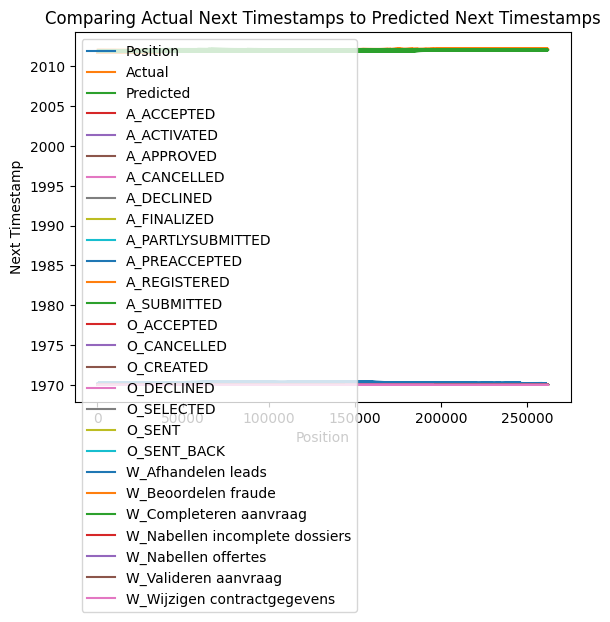

In [48]:
ax = results_df.plot(title = "Comparing Actual Next Timestamps to Predicted Next Timestamps")
ax.set_xlabel("Position")
ax.set_ylabel("Next Timestamp")


In [49]:
results_df

,Position,Actual,Predicted,A_ACCEPTED,A_ACTIVATED,A_APPROVED,A_CANCELLED,A_DECLINED,A_FINALIZED,A_PARTLYSUBMITTED,...,O_SELECTED,O_SENT,O_SENT_BACK,W_Afhandelen leads,W_Beoordelen fraude,W_Completeren aanvraag,W_Nabellen incomplete dossiers,W_Nabellen offertes,W_Valideren aanvraag,W_Wijzigen contractgegevens
195274,24,2012-02-24 09:15:35.424999936,2012-02-07 10:13:41.278784000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63404,89,2011-12-22 09:41:05.542000128,2011-12-05 01:16:30.638846464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
212393,38,2012-02-21 10:03:36.973999872,2012-02-02 17:15:47.264537088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
171542,9,2012-01-13 18:10:39.755000064,2012-02-03 05:18:33.731769344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
135979,30,2011-12-30 16:19:45.120000000,2011-11-19 11:01:28.650252288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208289,11,2012-02-01 12:31:51.644000000,2012-01-26 05:53:20.261348352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
230910,30,2012-03-08 10:51:03.582999808,2012-01-28 22:51:47.655539968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18451,3,2011-10-12 09:22:46.224000000,2011-11-24 12:07:44.815279360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
190601,13,2012-01-24 14:51:34.300999936,2012-01-31 06:11:30.003136000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [50]:
#df.to_csv("2012_preprocessed.csv")

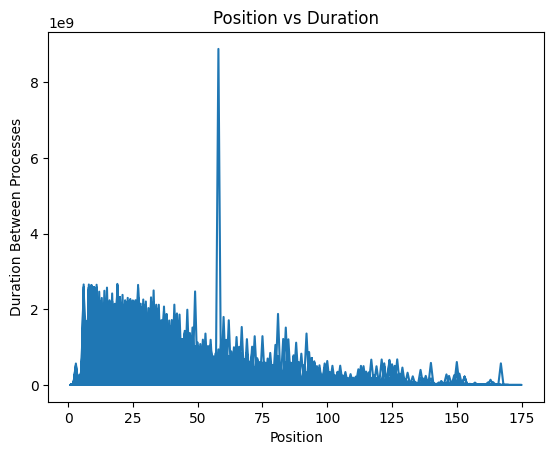

In [51]:
# Plot the time series
df.set_index("position", inplace = True)
plt.plot(df["duration"])
plt.title("Position vs Duration")
plt.xlabel("Position")
plt.ylabel("Duration Between Processes")
plt.show()
df.reset_index(inplace = True)

The plot indicates a potential time trend

In [52]:
"""
adf_test = adfuller(df["duration"])

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
"""


'\nadf_test = adfuller(df["duration"])\n\nprint(\'ADF Statistic: %f\' % adf_test[0])\nprint(\'p-value: %f\' % adf_test[1])\n'

In [53]:
"""

for key, value in adf_test[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

"""

"\n\nfor key, value in adf_test[4].items():\n    print('Critial Values:')\n    print(f'   {key}, {value}')\n\n"

In [54]:
#print('Number of Lags Used: %f' % adf_test[2])

In [55]:
#plot_acf(df["duration"], lags=62)
#plt.show()

In [56]:
#plot_pacf(df["duration"], lags=62)
#plt.show()

In [57]:
#Fit the ARIMA(1,0,1) model

model = ARIMA(df["duration"], order=(1, 0, 1))
model_fit = model.fit()

In [58]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               duration   No. Observations:               262200
Model:                 ARIMA(1, 0, 1)   Log Likelihood            -5296512.432
Date:                Thu, 04 Apr 2024   AIC                       10593032.864
Time:                        10:54:20   BIC                       10593074.771
Sample:                             0   HQIC                      10593045.055
                             - 262200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.718e+07   2.34e-11   1.59e+18      0.000    3.72e+07    3.72e+07
ar.L1         -0.8811      0.004   -245.483      0.000      -0.888      -0.874
ma.L1          0.7905      0.004    175.785      0.0

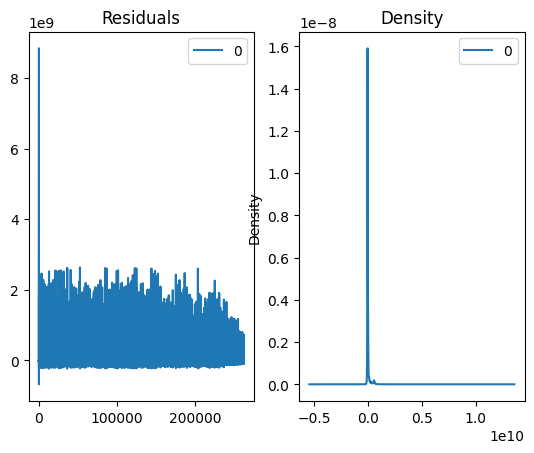

In [59]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [60]:
predictions = model_fit.predict()

In [61]:
"""
plt.figure(figsize=(10, 6))
plt.plot(df["duration"], label='Actual Data', color='blue')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual Data vs. ARIMA Predictions')
plt.legend()
plt.show()
"""

'\nplt.figure(figsize=(10, 6))\nplt.plot(df["duration"], label=\'Actual Data\', color=\'blue\')\nplt.plot(predictions, label=\'Predictions\', color=\'red\')\nplt.xlabel(\'Time\')\nplt.ylabel(\'Values\')\nplt.title(\'Actual Data vs. ARIMA Predictions\')\nplt.legend()\nplt.show()\n'

In [62]:
len(df)*0.8

209760.0

In [63]:
x = pd.DataFrame(df.groupby(df.index)["duration"].count())

x.iloc[0:33]["duration"].sum()

33

In [64]:
filtered_df = df[(df.index >= 0) & (df.index <= 33)]
filtered_df_2 = df[(df.index > 33)]

train = pd.DataFrame(filtered_df["duration"])
test = pd.DataFrame(filtered_df_2["duration"])

In [65]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 0, 1))  
fitted = model.fit()

# Training prediction
predictions = fitted.predict()

# Forecast
forecast = fitted.forecast(steps=len(test), index = test.index)



In [66]:
"""

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(predictions, label='prediction')
plt.title('Predictions (Training) vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

"""

"\n\n# Plot\nplt.figure(figsize=(12,5), dpi=100)\nplt.plot(train, label='training')\nplt.plot(test, label='actual')\nplt.plot(predictions, label='prediction')\nplt.title('Predictions (Training) vs Actual')\nplt.legend(loc='upper left', fontsize=8)\nplt.show()\n\n"

In [67]:
"""

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecast, label='forecast')
plt.title('Forecast (Testing) vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

"""

"\n\n# Plot\nplt.figure(figsize=(12,5), dpi=100)\nplt.plot(train, label='training')\nplt.plot(test, label='actual')\nplt.plot(forecast, label='forecast')\nplt.title('Forecast (Testing) vs Actual')\nplt.legend(loc='upper left', fontsize=8)\nplt.show()\n\n"

In [68]:
#  Automatically evaluates the best model based on the AIC

# Caution the code takes about 10 minutes to execute

#from statsmodels.tsa.arima_model import ARIMA
#import pmdarima as pm

#model = pm.auto_arima(df["duration"], start_p=1, start_q=1,
#                      test='adf',       # use adftest to find optimal 'd'
#                      max_p=3, max_q=3, # maximum p and q
#                      m=1,              # frequency of series
#                      d=None,           # let model determine 'd'
#                      seasonal=False,   # No Seasonality
#                      start_P=0, 
#                      D=0, 
#                      trace=True,
#                      error_action='ignore',  
#                      suppress_warnings=True, 
#                      stepwise=True)

#print(model.summary())

In [69]:
"""

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

mse_test = mean_squared_error(test, forecast)
mape_test = mean_absolute_percentage_error(test, forecast)

print("The mean squared error is: %f" %mse_test)
print("The mean absolute percentage error is: %f" %mape_test)

"""

'\n\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.metrics import mean_absolute_percentage_error\n\nmse_test = mean_squared_error(test, forecast)\nmape_test = mean_absolute_percentage_error(test, forecast)\n\nprint("The mean squared error is: %f" %mse_test)\nprint("The mean absolute percentage error is: %f" %mape_test)\n\n'

In [70]:
# Evaluating variance
##variance = np.var(forecast)

# Evaluating SSE
#SSE = np.mean((np.mean(forecast) - test)** 2)  
  # O/P : 85.03300391390214

# Evaluating Variance
#bias = SSE - variance
  # O/P : 28.482148757577583

#print(variance)
#print(SSE)
#print(bias)

In [71]:
#from arch import arch_model

# Define model
##model = arch_model(train, mean='Zero', vol='ARCH', p=15)
# Fit model
##model_fit = model.fit()
# Forecast the test set
#yhat = model_fit.forecast(horizon=n_test)




In [72]:
#import pm4py

#if __name__ == "__main__":
#    log = pm4py.read_xes('BPI_Challenge_2012.xes')


In [73]:
#map = pm4py.discover_heuristics_net(log)
#pm4py.view_heuristics_net(map)

In [74]:
#df

In [75]:
#from sklearn.preprocessing import OneHotEncoder

#enc = OneHotEncoder(handle_unknown='ignore')

#enc.fit(df[["concept:name"]])

#array = enc.transform(df[["concept:name"]]).toarray()

#df_one_hot = pd.DataFrame(array, columns = enc.get_feature_names_out())

In [76]:
#df = df.merge(df_one_hot, left_index = True, right_index = True)
#df

In [77]:
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error

#X = df[[enc.get_feature_names_out()]]
#y = df["Duration"]




In [78]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
#model = LinearRegression()
#model.fit(X_train, y_train)

# Make predictions on the testing set
#y_pred = model.predict(X_test)

# Evaluate model
#mse = mean_squared_error(y_test, y_pred)
#print("Mean Squared Error:", mse)

In [79]:
#import duckdb

In [80]:
#df

In [81]:
df_time_series = df.groupby("position")[["duration"]].mean()

In [82]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# Define ARIMA parameters
p = 1  # AR order
d = 0  # Integrated order (differencing)
q = 1  # MA order

# Initialize TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)



def evaluate_arima_model(train, test, order):
    history = list(train["duration"])
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test.iloc[t]["duration"])
    error = mean_absolute_error(test["duration"], predictions)
    return error

# Perform k-fold cross-validation with ARIMA model using MAE
errors = []
for train_idx, test_idx in tscv.split(df_time_series):
    train, test = df_time_series.iloc[train_idx], df_time_series.iloc[test_idx]
    error = evaluate_arima_model(train, test, order=(p, d, q))
    errors.append(error)

# Calculate mean absolute error across folds
mean_error = np.mean(errors)
print("Mean Absolute Error (MAE):", mean_error)

c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Aahaan\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Absolute Error (MAE): 14442587.40742222


In [83]:
mean_mae_hours = mean_error / (1000*60*60)
print(f'The mean average error in hours is {mean_mae_hours}')

The mean average error in hours is 4.011829835395061


<Axes: xlabel='position'>

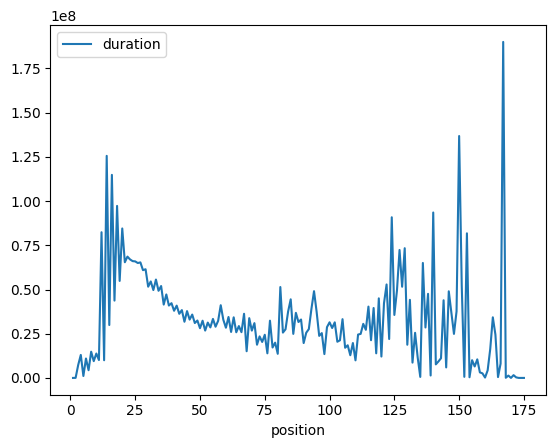

In [84]:
df_time_series.plot()

In [85]:
"""

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error


# Define ARIMA parameters
p = 1  # AR order
d = 0  # Integrated order (differencing)
q = 1  # MA order

# Initialize TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Initialize dictionary to store MAE for each variable combination
mae_dict = {}

# Define a function to evaluate ARIMA model using cross-validation with MAE
def evaluate_arima_model(train, test, order, variables):
    history = list(train["duration"])
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test.iloc[t]["duration"])
    error = mean_absolute_error(test["duration"], predictions)
    mae_dict[tuple(variables)] = mae_dict.get(tuple(variables), []) + [error]
    return error

# Perform k-fold cross-validation with ARIMA model using MAE for different feature combinations
for train_idx, test_idx in tscv.split(df):
    train, test = df.iloc[train_idx], df.iloc[test_idx]
    # Generate all possible feature combinations
    features = df.columns.drop(['date',])  # Exclude date and target value columns
    for r in range(1, len(features) + 1):
        for combo in combinations(features, r):
            error = evaluate_arima_model(train, test, order=(p, d, q), variables=combo)

# Calculate mean MAE for each feature combination
mean_mae_dict = {variables: np.mean(errors) for variables, errors in mae_dict.items()}
print("Mean Absolute Error (MAE) for each feature combination:")
for variables, mean_mae in mean_mae_dict.items():
    print(f"Variables: {variables}, Mean MAE: {mean_mae}")
    
"""


'\n\nfrom sklearn.model_selection import TimeSeriesSplit\nfrom sklearn.metrics import mean_absolute_error\n\n\n# Define ARIMA parameters\np = 1  # AR order\nd = 0  # Integrated order (differencing)\nq = 1  # MA order\n\n# Initialize TimeSeriesSplit cross-validator\ntscv = TimeSeriesSplit(n_splits=5)\n\n# Initialize dictionary to store MAE for each variable combination\nmae_dict = {}\n\n# Define a function to evaluate ARIMA model using cross-validation with MAE\ndef evaluate_arima_model(train, test, order, variables):\n    history = list(train["duration"])\n    predictions = []\n    for t in range(len(test)):\n        model = ARIMA(history, order=order)\n        model_fit = model.fit()\n        yhat = model_fit.forecast()[0]\n        predictions.append(yhat)\n        history.append(test.iloc[t]["duration"])\n    error = mean_absolute_error(test["duration"], predictions)\n    mae_dict[tuple(variables)] = mae_dict.get(tuple(variables), []) + [error]\n    return error\n\n# Perform k-fold c

In [86]:
mean_mae_hours = mean_error / (1000*60*60)
mean_mae_hours

4.011829835395061

In [87]:
#log_2018 = pm4py.read_xes("BPI Challenge 2018.xes")
#df_2018 = pm4py.convert_to_dataframe(log_2018)

In [88]:
#df_2018

In [89]:
#df_time_series

In [90]:
df_linear_regression = df_linear_regression.sort_values(by=['case:concept:name', 'position'])

In [91]:
df_linear_regression.set_index("case:concept:name", inplace = True)

In [92]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_linear_regression["month"] = scaler.fit_transform(df_linear_regression[["month"]])



In [93]:
df_linear_regression["day"] = scaler.fit_transform(df_linear_regression[["day"]])
df_linear_regression["time_until_midnight"] = scaler.fit_transform(df_linear_regression[["time_until_midnight"]])
df_linear_regression["time_elapsed_since_previous_event"] = scaler.fit_transform(df_linear_regression[["time_elapsed_since_previous_event"]])
df_linear_regression["time_since_start"] = scaler.fit_transform(df_linear_regression[["time_since_start"]])

In [94]:
df_linear_regression["case:AMOUNT_REQ"] = scaler.fit_transform(df_linear_regression[["case:AMOUNT_REQ"]])

In [95]:
df_linear_regression.reset_index(inplace = True)

In [96]:
df_lstm = df_linear_regression[["case:concept:name", "month", "day", "time_until_midnight", "time_elapsed_since_previous_event", "time_since_start", "case:AMOUNT_REQ"]]

In [97]:
"""
import numpy as np
import tensorflow as tf

# Define the LSTM model with masking
class MaskedLSTMModel(tf.keras.Model):
    def __init__(self, lstm_units):
        super(MaskedLSTMModel, self).__init__()
        self.lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(1)  # Output layer for predicting one timestamp value

    def call(self, inputs, training=None):
        mask = self.compute_mask(inputs)
        lstm_output, final_memory_state, _ = self.lstm(inputs, mask=mask)
        output = self.dense(lstm_output)
        return output

    def compute_mask(self, inputs):
        return tf.reduce_any(tf.not_equal(inputs, 0.0), axis=-1)  # Assuming 0.0 is the padding value

# Example usage
lstm_units = 64  # Number of LSTM units

model = MaskedLSTMModel(lstm_units)

# Generate random variable-length input data (example)
input_data = df_lstm

# Forward pass through the model (with masking)
output = model(input_data)

# Print model summary and check output shape
model.summary()
print("Input data shape:", input_data.shape)
print("Output shape (predictions):", output.shape)

"""



'\nimport numpy as np\nimport tensorflow as tf\n\n# Define the LSTM model with masking\nclass MaskedLSTMModel(tf.keras.Model):\n    def __init__(self, lstm_units):\n        super(MaskedLSTMModel, self).__init__()\n        self.lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True)\n        self.dense = tf.keras.layers.Dense(1)  # Output layer for predicting one timestamp value\n\n    def call(self, inputs, training=None):\n        mask = self.compute_mask(inputs)\n        lstm_output, final_memory_state, _ = self.lstm(inputs, mask=mask)\n        output = self.dense(lstm_output)\n        return output\n\n    def compute_mask(self, inputs):\n        return tf.reduce_any(tf.not_equal(inputs, 0.0), axis=-1)  # Assuming 0.0 is the padding value\n\n# Example usage\nlstm_units = 64  # Number of LSTM units\n\nmodel = MaskedLSTMModel(lstm_units)\n\n# Generate random variable-length input data (example)\ninput_data = df_lstm\n\n# Forward pass through the model (with ma

In [98]:
#df_lstm.groupby("case:concept:name").count()["month"]

In [99]:
"""

import pandas as pd
import numpy as np
from scipy.sparse import dok_matrix

# Generate sample data (replace this with your actual data loading code)
np.random.seed(0)
data = pd.DataFrame({
    'duration': np.random.randint(1, 50, 100)  # Sample numeric data for 'duration'
})

def create_transition_matrix(data, order):
    # Create transition matrix based on the specified order
    num_states = len(np.unique(data))
    transition_matrix = dok_matrix((num_states,) * (order + 1), dtype=np.int32)
    
    state_idx_map = {state: idx for idx, state in enumerate(np.unique(data))}
    states = data.values
    for i in range(len(states) - order):
        current_state = tuple(state_idx_map[states[i + j]] for j in range(order))
        next_state = state_idx_map[states[i + order]]
        transition_matrix[current_state, next_state] += 1
    
    # Normalize transition matrix to probabilities
    row_sums = transition_matrix.sum(axis=1)
    transition_matrix = transition_matrix / row_sums[:, np.newaxis]
    
    return transition_matrix, state_idx_map

def predict_next_state(transition_matrix, state_idx_map, current_state):
    # Predict the next state based on the transition matrix
    if current_state in state_idx_map:
        current_state_idx = state_idx_map[current_state]
        next_state_probs = transition_matrix[current_state_idx].toarray().flatten()
        next_state_idx = np.argmax(next_state_probs)
        next_state = next(key for key, value in state_idx_map.items() if value == next_state_idx)
        return next_state
    else:
        return None

def generate_sequence(data, order, sequence_length):
    # Generate a sequence of predicted states
    transition_matrix, state_idx_map = create_transition_matrix(data, order)
    last_observed_states = tuple(data.iloc[-order:])
    predicted_sequence = []
    for _ in range(sequence_length):
        next_state = predict_next_state(transition_matrix, state_idx_map, last_observed_states)
        if next_state is not None:
            predicted_sequence.append(next_state)
            last_observed_states = (*last_observed_states[1:], next_state)
        else:
            break
    return predicted_sequence

# Example usage
order = 2  # Choose the order of the Markov chain
sequence_length = 10  # Length of the predicted sequence
predicted_sequence = generate_sequence(data['duration'], order, sequence_length)
print("Predicted Sequence:", predicted_sequence)

"""


'\n\nimport pandas as pd\nimport numpy as np\nfrom scipy.sparse import dok_matrix\n\n# Generate sample data (replace this with your actual data loading code)\nnp.random.seed(0)\ndata = pd.DataFrame({\n    \'duration\': np.random.randint(1, 50, 100)  # Sample numeric data for \'duration\'\n})\n\ndef create_transition_matrix(data, order):\n    # Create transition matrix based on the specified order\n    num_states = len(np.unique(data))\n    transition_matrix = dok_matrix((num_states,) * (order + 1), dtype=np.int32)\n    \n    state_idx_map = {state: idx for idx, state in enumerate(np.unique(data))}\n    states = data.values\n    for i in range(len(states) - order):\n        current_state = tuple(state_idx_map[states[i + j]] for j in range(order))\n        next_state = state_idx_map[states[i + order]]\n        transition_matrix[current_state, next_state] += 1\n    \n    # Normalize transition matrix to probabilities\n    row_sums = transition_matrix.sum(axis=1)\n    transition_matrix = t

In [100]:
#data = df[["case:concept:name", "position", "concept:name"]]

In [101]:
"""

from scipy.sparse import dok_matrix
from scipy.sparse import csr_matrix


def create_transition_matrix(sequence_data, order):
    # Create transition matrix based on the specified order for a single sequence
    num_states = len(np.unique(sequence_data["concept:name"]))
    transition_matrix = np.zeros((num_states ** order, num_states), dtype=np.int32)

    state_idx_map = {state: idx for idx, state in enumerate(np.unique(sequence_data["concept:name"]))}
    states = sequence_data["concept:name"].values
    for i in range(len(states) - order):
        current_state_idx = tuple(state_idx_map[states[i + j]] for j in range(order))
        next_state_idx = state_idx_map[states[i + order]]
        transition_matrix[current_state_idx, next_state_idx] += 1

    # Convert transition matrix to CSR format for efficient matrix operations
    return csr_matrix(transition_matrix), state_idx_map

def predict_next_state(transition_matrix, state_idx_map, current_state):
    # Predict the next state based on the transition matrix and current state
    if current_state in state_idx_map:
        current_state_idx = state_idx_map[current_state]
        next_state_probs = transition_matrix[current_state_idx].toarray().flatten()
        next_state_idx = np.argmax(next_state_probs)
        next_state = next(key for key, value in state_idx_map.items() if value == next_state_idx)
        return next_state
    else:
        return None

def generate_predictions(test_sequence, transition_matrix, state_idx_map, order, sequence_length):
    # Generate predictions for a testing sequence using the Markov chain model
    predicted_sequence = []
    last_observed_states = tuple(test_sequence[-order:])
    for _ in range(sequence_length):
        next_state = predict_next_state(transition_matrix, state_idx_map, last_observed_states)
        if next_state is not None:
            predicted_sequence.append(next_state)
            last_observed_states = (*last_observed_states[1:], next_state)
        else:
            break
    return predicted_sequence

# Example usage
order = 2  # Choose the order of the Markov chain
sequence_length = 5  # Length of the predicted sequence

# Create transition matrix for a single sequence (example using first sequence)
sequence_id = 173688
sequence_data = data[data["case:concept:name"] == sequence_id]
transition_matrix, state_idx_map = create_transition_matrix(sequence_data, order)

# Define a testing sequence (replace this with your actual testing sequence)
testing_sequence = ["A_SUBMITTED"]  # Example initial testing sequence

# Generate predictions for the testing sequence
predicted_sequence = generate_predictions(testing_sequence, transition_matrix, state_idx_map, order, sequence_length)
print("Testing Sequence:", testing_sequence)
print("Predicted Sequence:", predicted_sequence)

"""

'\n\nfrom scipy.sparse import dok_matrix\nfrom scipy.sparse import csr_matrix\n\n\ndef create_transition_matrix(sequence_data, order):\n    # Create transition matrix based on the specified order for a single sequence\n    num_states = len(np.unique(sequence_data["concept:name"]))\n    transition_matrix = np.zeros((num_states ** order, num_states), dtype=np.int32)\n\n    state_idx_map = {state: idx for idx, state in enumerate(np.unique(sequence_data["concept:name"]))}\n    states = sequence_data["concept:name"].values\n    for i in range(len(states) - order):\n        current_state_idx = tuple(state_idx_map[states[i + j]] for j in range(order))\n        next_state_idx = state_idx_map[states[i + order]]\n        transition_matrix[current_state_idx, next_state_idx] += 1\n\n    # Convert transition matrix to CSR format for efficient matrix operations\n    return csr_matrix(transition_matrix), state_idx_map\n\ndef predict_next_state(transition_matrix, state_idx_map, current_state):\n    # 

#### Recursive Suffix Prediction Model:

In [102]:
import math

timestamp_array = []

mean_positions = df_linear_regression.groupby("case:concept:name")["position"].max()

mean_positions = math.ceil(mean_positions.mean())


# Prfix timestamps in milliseconds

initial_array = [334.0, 53026.0, 969.0]

# List to store averages
averages_list = []


for i in range(1, mean_positions):
    # Calculate the average of the initial array
    avg_array = sum(initial_array) / len(initial_array)
    
    # Calculate the average of the average and the previous element
    if i == 1:
        avg_prev = avg_array  # For the first iteration, use the average of the array itself
    else:
        avg_prev = (avg_array + initial_array[-2]) / 2
    
    # Append the average of the array and the previous element to the initial array
    initial_array.append(avg_prev)
    
    # Append the extended array to the list
    averages_list.append(initial_array.copy())

# Print the timestamps of all events in the trace. The timestamp here is the time elapsed since the beginning of the process.
for array in averages_list:
    print(np.sum(array) / (1000*60*60))



0.020121851851851853
0.022771666666666666
0.027564064814814816
0.031185977623456793
0.03580974652777778
0.03985881209008488
0.04438507499169453
0.04862886152243281
0.05310239576971185
0.05743688885881899
0.06188276709241308
0.06626011246169569
0.0706917219938826
0.07508951099083272
0.07951383078606832
0.08392144280637862
0.0883420617252169
0.09275441927850248
0.09717316729217168


In [103]:
"""
prefix_length = 2

df_test = df_linear_regression[df_linear_regression["position"] == prefix_length][["position","time_since_start", "duration"]]
"""

'\nprefix_length = 2\n\ndf_test = df_linear_regression[df_linear_regression["position"] == prefix_length][["position","time_since_start", "duration"]]\n'

In [104]:
"""

num_iterations = 10

for i in range(0, num_iterations):
    
    if i == 0:
        prev_column_name = "duration"
        prev_time_since_start = "time_since_start"
    
    else:
        prev_column_name = f'duration_{i}'
        prev_time_since_start = f'time_since_start_{i}'
    
    new_column_name = f'duration_{i + 1}'
    new_time_since_start = f'time_since_start{i + 1}'

    df_test[new_time_since_start] = 




    df_test[new_column_name] = df_test[prev_column_name] = time_since_start[1000]

"""


'\n\nnum_iterations = 10\n\nfor i in range(0, num_iterations):\n    \n    if i == 0:\n        prev_column_name = "duration"\n        prev_time_since_start = "time_since_start"\n    \n    else:\n        prev_column_name = f\'duration_{i}\'\n        prev_time_since_start = f\'time_since_start_{i}\'\n    \n    new_column_name = f\'duration_{i + 1}\'\n    new_time_since_start = f\'time_since_start{i + 1}\'\n\n    df_test[new_time_since_start] = \n\n\n\n\n    df_test[new_column_name] = df_test[prev_column_name] = time_since_start[1000]\n\n'

In [105]:
"""

num_iterations = 10



# Perform recursive calculation for new columns
for i in range(num_iterations):
    prev_column_name = f'duration_{i}' if i > 0 else 'duration'  # Handle first iteration
    prev_time_since_start = f'time_since_start_{i}' if i > 0 else 'time_since_start'  # Handle first iteration

    if i > 0:

        df_test[f'duration_{i}'] = (df_test[f'time_since_start_{i}'] / i)
    
    
    # Calculate the average of previous time_since_start and previous duration
    df_test[f'avg_time_since_start_{i+1}'] = (df_test[prev_time_since_start] + df_test[f'duration_{i + 1}']) / (i+1)
    
    # Calculate the new duration
    
    
    # Update the time_since_start for the next iteration
    df_test[f'time_since_start_{i+1}'] = df_test[f'avg_time_since_start_{i+1}']


df_test

"""

"\n\nnum_iterations = 10\n\n\n\n# Perform recursive calculation for new columns\nfor i in range(num_iterations):\n    prev_column_name = f'duration_{i}' if i > 0 else 'duration'  # Handle first iteration\n    prev_time_since_start = f'time_since_start_{i}' if i > 0 else 'time_since_start'  # Handle first iteration\n\n    if i > 0:\n\n        df_test[f'duration_{i}'] = (df_test[f'time_since_start_{i}'] / i)\n    \n    \n    # Calculate the average of previous time_since_start and previous duration\n    df_test[f'avg_time_since_start_{i+1}'] = (df_test[prev_time_since_start] + df_test[f'duration_{i + 1}']) / (i+1)\n    \n    # Calculate the new duration\n    \n    \n    # Update the time_since_start for the next iteration\n    df_test[f'time_since_start_{i+1}'] = df_test[f'avg_time_since_start_{i+1}']\n\n\ndf_test\n\n"